# Notebook setup

Importing the necessary stuff to run the montecarlo simulation.

## Packages setup

In [1]:
#Basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from colorsetup import colors, palette
from scipy import stats
from scipy.stats import norm, lognorm
import pickle

In [2]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, make_scorer, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
#Defining negative prediction based classification metrics
specificity = make_scorer(precision_score, pos_label = 0)
npv = make_scorer(recall_score, pos_label = 0)

In [4]:
#Helper function to plot histograms
def plot_hist(n, m, data):
    fig, axList = plt.subplots(nrows=n, ncols=m)
    axList = axList.flatten()
    fig.set_size_inches(18,3*n)
    for ax in enumerate(axList):
        loc = ax[0]
        ax = ax[1]
        if loc < len(data.columns):
            sns.histplot(data, x = data.iloc[:,loc], ax = ax, legend = False)
            mean = np.around(np.mean(data.iloc[:,loc]), 2)
            s_dev = np.around(np.std(data.iloc[:,loc]), 3)
            ax.set(title= 'Mean: ' + str(mean) + ', Std: ' + str(s_dev))
        if loc >= len(data.columns):
            ax.axis("off")
    plt.tight_layout()

## Loading trained models and test data

In [4]:
#Recover the trained models and the test data.
trained_models = pickle.load(open('trained_models.p', 'rb'))
X_train, y_train, X_test, y_test = pickle.load(open('training_splits.p', 'rb')).values()
df = pd.read_csv('credit.csv')
df.drop(columns = 'telephone', inplace = True)

# Montecarlo Simulation

## Montecarlo simulation setup

### Helper functions

In [677]:
#Create a dictionary with the probability of each label to be used with random.choice and norm.rvs 
#to create the Monte Carlo Simulation
p = {}
for column in df.columns:
    #If the amount of labels is less than 50, we get the probability of each label:
    if len(df[column].value_counts()) <= 50:
        p[column] = {'a': list(df[column].value_counts(normalize = True).index),
                     'p': list(df[column].value_counts(normalize = True))}
    #If the amount of labels is greater than 11, we fit a skewed normal distribution to get the parameters 
    #that can be used to random sample from the column.
    else:
        p[column] = {'loc': norm.fit(df[column])[0],
                    'scale': norm.fit(df[column])[1]}

### Simulation samples

(0.5284890634339938,
 0.22425913343872164,
 -0.1968298915054456,
 1.2505809825130252)

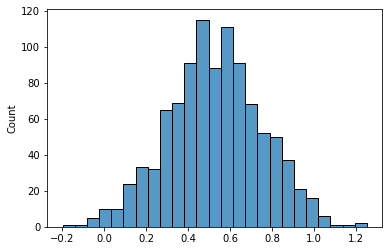

In [7]:
#Create a normal distribution according to the fit parameters for the age column:
col = 'age'
r = norm.rvs(size=1000, loc = p[col]['loc'], scale = p[col]['scale'])
sns.histplot(r, legend = False)
np.mean(r), np.std(r), min(r), max(r)

In [8]:
df.age.describe().T

count    1000.000000
mean        0.533704
std         0.220017
min         0.000000
25%         0.372850
50%         0.539476
75%         0.706588
max         1.000000
Name: age, dtype: float64

(0.483177148787776, 0.20082791448325424, 0.0, 1.0)

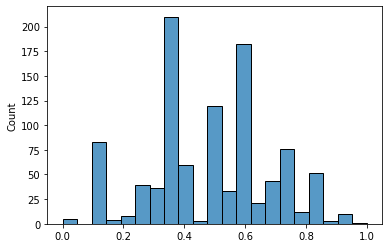

In [9]:
column = 'duration'
dur = np.random.choice(a = p[column]['a'], size = 1000, p = p[column]['p'])
sns.histplot(dur, legend = False)
np.mean(dur), np.std(dur), min(dur), max(dur)

In [10]:
df.age.describe()

count    1000.000000
mean        0.533704
std         0.220017
min         0.000000
25%         0.372850
50%         0.539476
75%         0.706588
max         1.000000
Name: age, dtype: float64

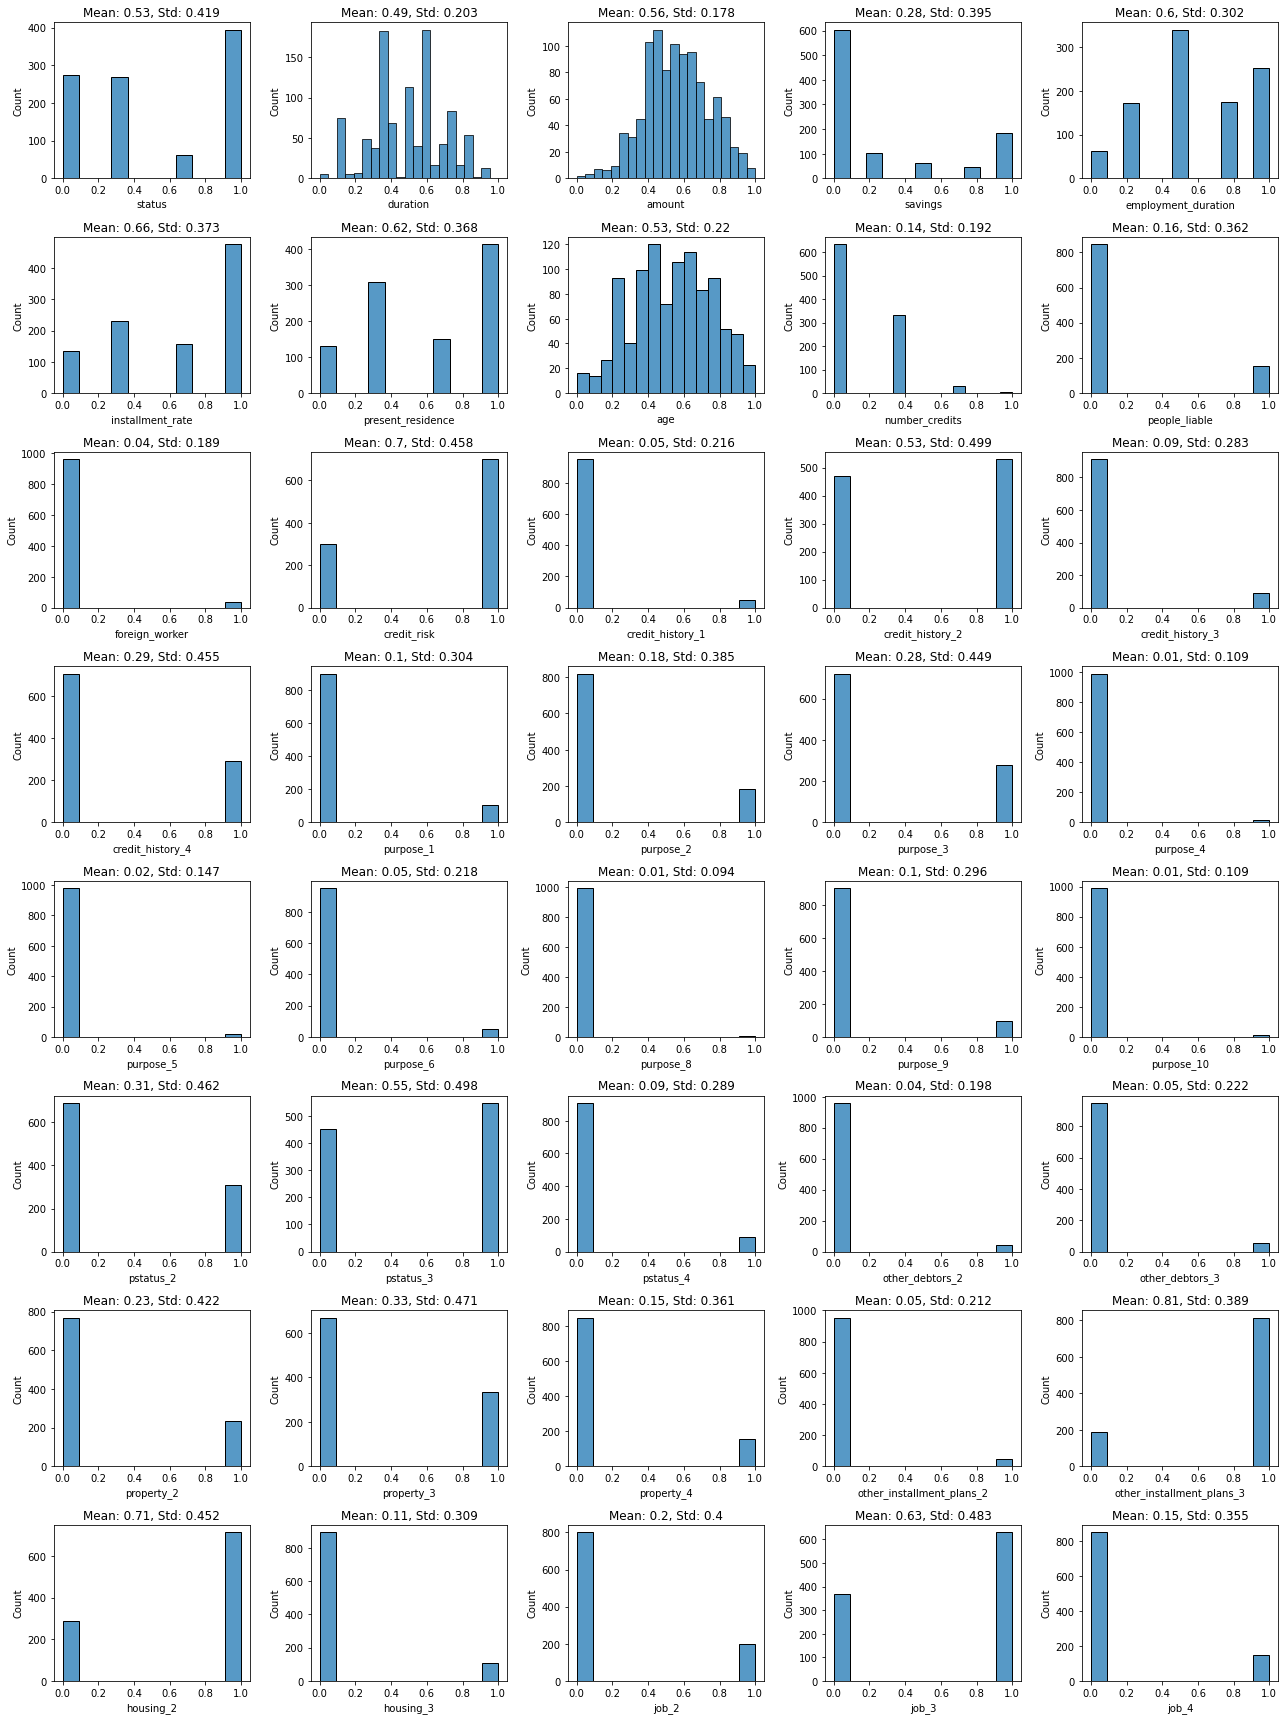

In [674]:
plot_hist(8,5,df)
plt.savefig('Base Data Histograms.png', bbox_inches = 'tight')

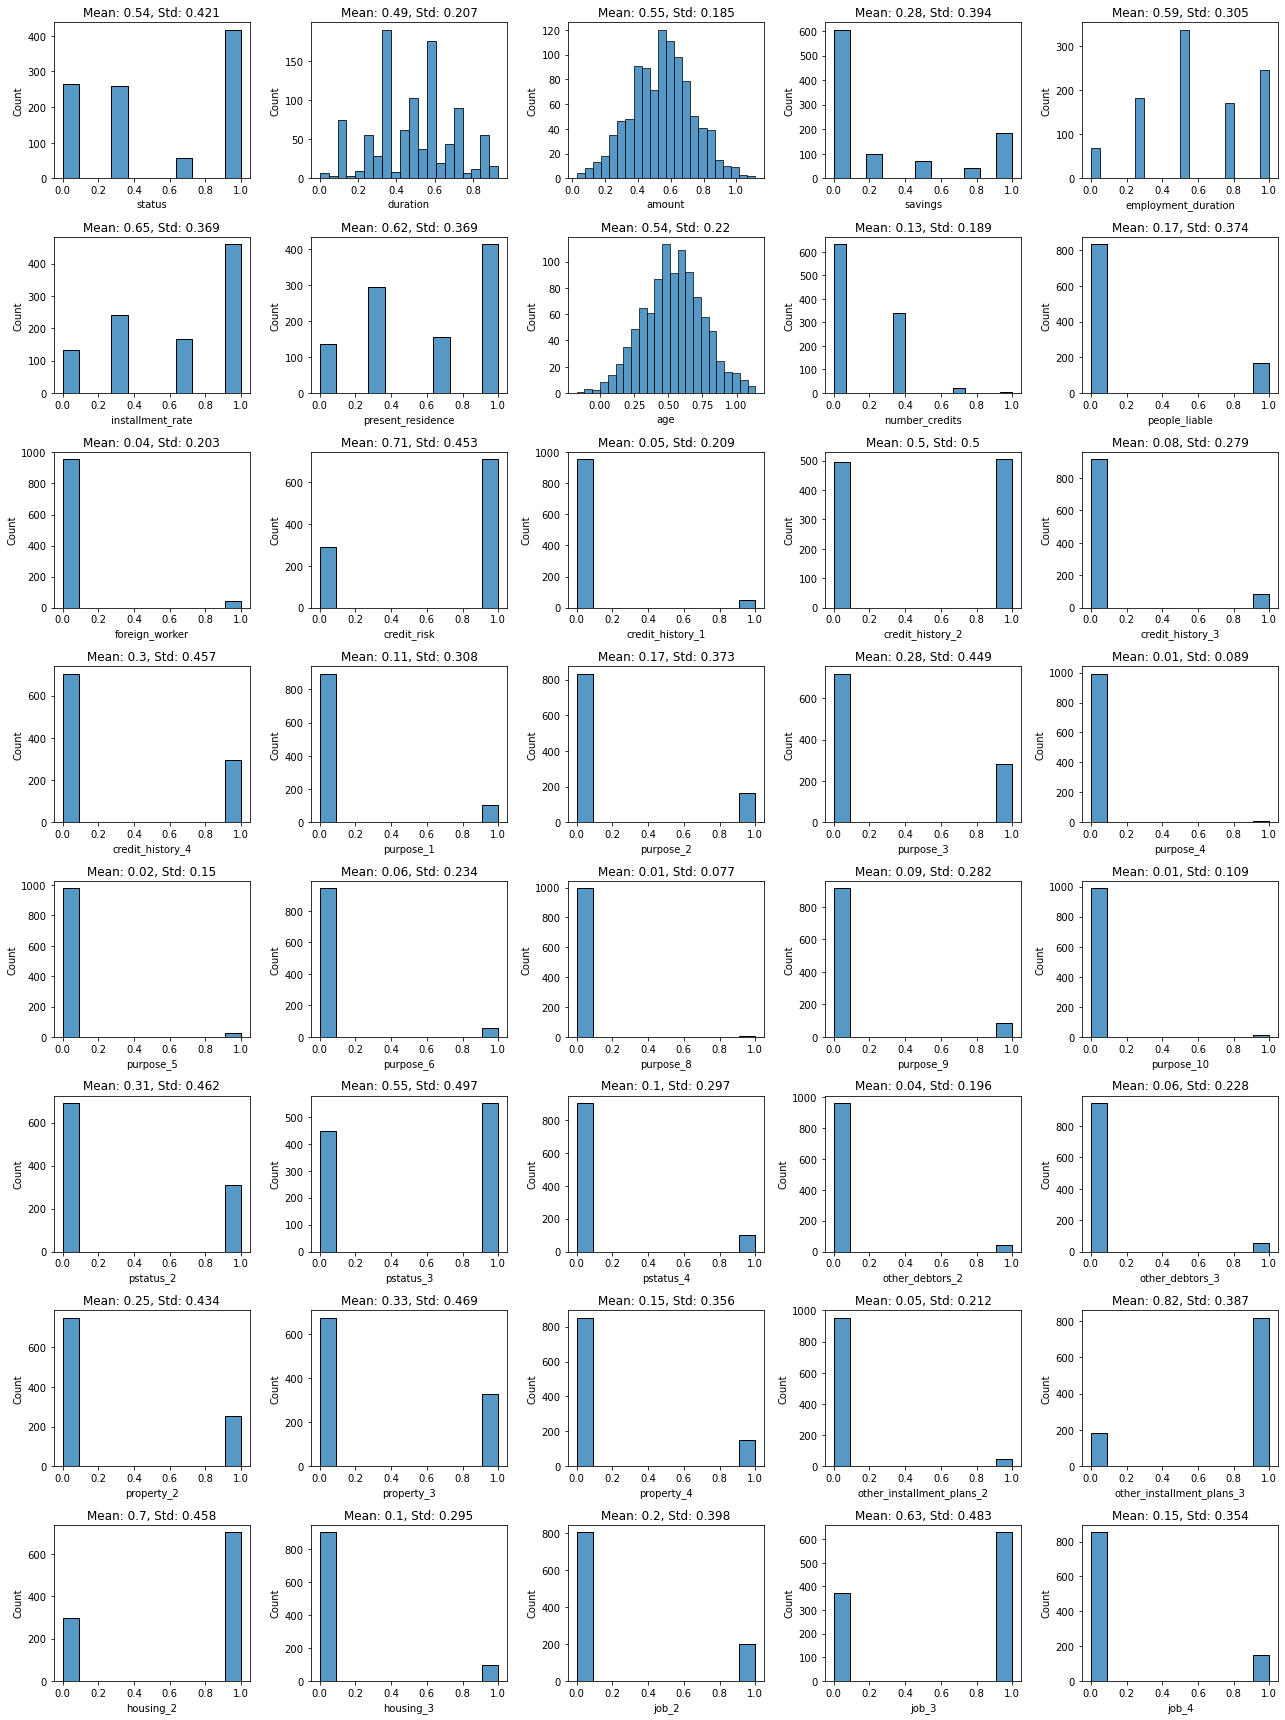

In [678]:
test_frame = generate_test(p, 1000)
plot_hist(8,5,test_frame)
plt.savefig('Simulated Data Histograms.png', bbox_inches = 'tight')

## Simulation on the models

In [6]:
base_models = list(trained_models['Base Models'].values())
base_models

[SVC(C=1, random_state=42),
 SVC(C=0.001, class_weight='balanced', probability=True, random_state=42),
 LogisticRegression(C=0.1, solver='liblinear'),
 KNeighborsClassifier(n_neighbors=30),
 KNeighborsClassifier(n_neighbors=4)]

In [676]:
#Function to generate a simulation dataframe based on the distributions of the initial data.
#This function takes the probability distributions of each column and the size that's desired.
def generate_test(p, size):
    test = pd.DataFrame(columns = df.columns)
    for column in df.columns:
        #If the amount of labels is less than 50, we use random.choice:
        if len(df[column].value_counts()) <= 50:
            test[column] = np.random.choice(a = p[column]['a'], size = size, p = p[column]['p'])
        #If the amount of labels is greater than 11, we use skewed.rvs:
        else:
            test[column] = norm.rvs(size=size , loc = p[column]['loc'], scale = p[column]['scale'])
    return test

In [28]:
#Function that fits the passed model the amount of times given by 'iterations'
#each iteration starts from the previously created metrics.
#Each iteration runs with a radomly generated sample according to 'sample_size'
#p is the probability distributions of each column
#model is the model being tested
def run_montecarlo(iterations, sample_size, p, model, metrics):
    start = metrics.shape[0] + 1
    end = iterations 
    for i in range(start , end + 1):
        #Generate the random test.
        x_test_random = generate_test(p, sample_size)
        y_test_random = x_test_random.pop('credit_risk')
        y_predict_random = model.predict(x_test_random)
        precision, recall, fscore, _ = score(y_test_random, y_predict_random, average='binary', zero_division = 0)
        accuracy = accuracy_score(y_test_random, y_predict_random)
        spc = precision_score(y_test_random, y_predict_random, pos_label = 0, average = 'binary', zero_division = 0)
        npv = recall_score(y_test_random, y_predict_random, pos_label = 0, average = 'binary', zero_division = 0)
        #Generate the metrics for the current iteration:
        line = pd.Series({'precision':precision, 
                          'recall':recall, 
                          'fscore':fscore, 
                          'specificity' : spc, 
                          'npv' : npv, 
                          'accuracy':accuracy}, name = i)
        metrics = metrics.append(line)   
    return metrics

In [13]:
#Initialize the metrics dataframe
def initialize_metrics():
    metrics_columns = ['precision', 
                       'recall', 'fscore', 
                       'specificity', 
                       'npv', 
                       'accuracy']
    metrics = pd.DataFrame(columns = metrics_columns).rename_axis('Iterations')
    return metrics

In [14]:
metrics = initialize_metrics()
metrics

,precision,recall,fscore,specificity,npv,accuracy
Iterations,,,,,,


In [17]:
metrics = run_montecarlo(1, 100, p, base_models[4], metrics)
metrics

,precision,recall,fscore,specificity,npv,accuracy
Iterations,,,,,,
1,0.701493,0.681159,0.691176,0.333333,0.354839,0.58


In [18]:
#Initialize the results dataframe, it will hold the min, mean and max values of all the iterations up to 1000:
def initialize_results():
    cols = ['min', 'mean', 'max']
    measures = metrics.columns
    col_levels = pd.MultiIndex.from_product([cols, measures])
    results = pd.DataFrame(columns = col_levels).rename_axis('Iterations')
    return results

In [19]:
results = initialize_results()
results

Empty DataFrame
Columns: [(min, precision), (min, recall), (min, fscore), (min, specificity), (min, npv), (min, accuracy), (mean, precision), (mean, recall), (mean, fscore), (mean, specificity), (mean, npv), (mean, accuracy), (max, precision), (max, recall), (max, fscore), (max, specificity), (max, npv), (max, accuracy)]
Index: []

In [20]:
#Helper function to append the statistics of the metrics generated by the simulation
def append_results(metrics, results):
    line = pd.concat([metrics.min(), metrics.mean(), metrics.max()], keys = ['min', 'mean', 'max']).rename(index = metrics.shape[0])
    results = results.append(line)
    return results

In [21]:
#Defining the amount of iterations
iterations = list(range(1,10))
ten_steps = list(range(10,100,10))
hundred_steps = list(range(100,1050,50))
iterations.extend(ten_steps)
iterations.extend(hundred_steps)

In [23]:
iterations

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000]

In [268]:
metrics = initialize_metrics()
results = initialize_results()

In [269]:
#Test the functions with the base SVC model.
for i in iterations:
    metrics = run_montecarlo(i, 100, p, base_models[0], metrics)
    results = append_results(metrics, results)

In [270]:
results

min                                                     \
           precision    recall    fscore specificity       npv accuracy   
Iterations                                                                
1           0.707865  0.900000  0.792453    0.363636  0.133333     0.67   
2           0.609756  0.806452  0.694444    0.333333  0.133333     0.56   
3           0.609756  0.806452  0.694444    0.300000  0.096774     0.56   
4           0.609756  0.806452  0.694444    0.300000  0.096774     0.56   
5           0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
6           0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
7           0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
8           0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
9           0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
10          0.609756  0.806452  0.694444    0.125000  0.040000     0.56   
20          0.609756  0.800000  0.694444    0.071429  0.035714     0.56   
30          0.600000  0.774194  0.676056    0.071429  0.031250     0.54   
40          0.600000  0.750000  0.676056    0.071429  0.031250     0.54   
50          0.600000  0.750000  0.676056    0.071429  0.031250     0.54   
60          0.584270  0.750000  0.676056    0.071429  0.031250     0.54   
70          0.584270  0.750000  0.676056    0.071429  0.031250     0.54   
80          0.584270  0.750000  0.676056    0.071429  0.031250     0.54   
90          0.569767  0.750000  0.676056    0.071429  0.031250     0.54   
100         0.569767  0.750000  0.676056    0.000000  0.000000     0.54   
150         0.560976  0.750000  0.657143    0.000000  0.000000     0.52   
200         0.560976  0.750000  0.656934    0.000000  0.000000     0.52   
250         0.560976  0.750000  0.656934    0.000000  0.000000     0.51   
300         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
350         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
400         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
450         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
500         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
550         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
600         0.560976  0.681159  0.652778    0.000000  0.000000     0.50   
650         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
700         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
750         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
800         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
850         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
900         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
950         0.500000  0.681159  0.613139    0.000000  0.000000     0.47   
1000        0.500000  0.681159  0.613139    0.000000  0.000000     0.47   

                mean                                                      \
           precision    recall    fscore specificity       npv  accuracy   
Iterations                                                                 
1           0.707865  0.900000  0.792453    0.363636  0.133333  0.670000   
2           0.658811  0.853226  0.743449    0.348485  0.145614  0.615000   
3           0.668837  0.868334  0.755590    0.332323  0.129334  0.626667   
4           0.679753  0.854822  0.756693    0.336742  0.155334  0.630000   
5           0.691628  0.865191  0.768229    0.294394  0.132267  0.642000   
6           0.699463  0.867389  0.773935    0.286995  0.129453  0.648333   
7           0.702268  0.870460  0.776949    0.284957  0.126266  0.651429   
8           0.708962  0.869986  0.780762    0.285051  0.130483  0.656250   
9           0.706343  0.876015  0.781466    0.313985  0.135593  0.657778   
10          0.705823  0.874329  0.780535    0.305664  0.132378  0.656000   
20          0.708735  0.8724

<AxesSubplot:title={'center':'SCV Simulation'}, xlabel='Iterations'>

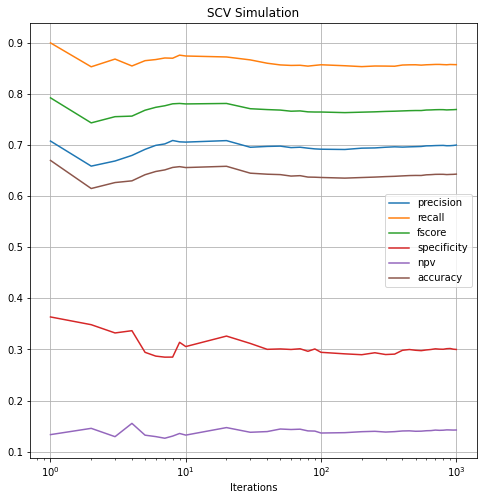

In [291]:
#Plot the result of the simulation
results['mean'].plot(figsize = (8,8), title = 'SCV Simulation', grid = True, logx = True)

<AxesSubplot:title={'center':'npv'}, xlabel='Iterations'>

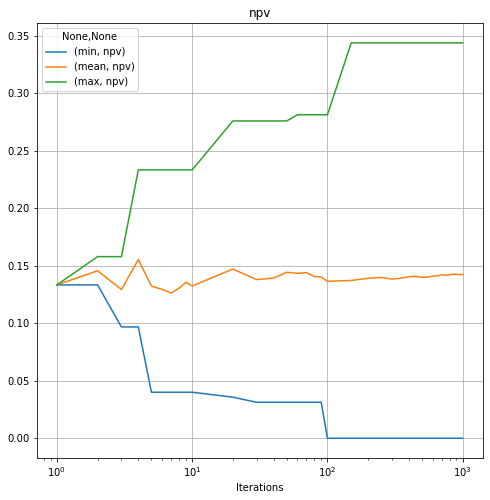

In [316]:
target_metric = 'npv'
pd.concat([results['min', target_metric],results['mean', target_metric], results['max', target_metric]], axis = 1).plot(figsize = (8,8), title = target_metric, grid = True, logx = True)

### Simulation of the base models

In [335]:
#Initialize the dictionary to store the result of the simulations
base_models_simulations = {}
#Iterate over each model on the base models
for name, model in trained_models['Base Models'].items():
    #Initialize the metrics and results dataframe for the current model
    metrics = initialize_metrics()
    results = initialize_results()
    #Run the simulation on the model
    for i in iterations:
        metrics = run_montecarlo(i, 100, p, model, metrics)
        results = append_results(metrics, results)
    #Save the results on the dictionary
    base_models_simulations[name + ' Simulation'] = results

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classificat

In [343]:
#Save to a pickle the dictionary with the results of the base models simulations
pickle.dump(base_models_simulations, open('base_models_simulations.p', 'wb'))

In [25]:
trained_models.keys()

dict_keys(['Base Models', 'AdaBoost Models', 'Voting Models', 'Tree Models'])

In [39]:
trained_models['Voting Models']

{'voting_hard': VotingClassifier(estimators=[('ada_dt',
                               AdaBoostClassifier(n_estimators=100,
                                                  random_state=42)),
                              ('gs_ada_dt',
                               AdaBoostClassifier(learning_rate=0.5,
                                                  random_state=42))]),
 'voting_soft': VotingClassifier(estimators=[('ada_dt',
                               AdaBoostClassifier(n_estimators=100,
                                                  random_state=42)),
                              ('gs_ada_dt',
                               AdaBoostClassifier(learning_rate=0.5,
                                                  random_state=42))],
                  voting='soft')}

### Simulation of the AdaBoost Models

In [29]:
#Initialize the dictionary to store the result of the simulations
AdaBoost_models_simulations = {}
#Iterate over each model on the ADaBoost models
for name, model in trained_models['AdaBoost Models'].items():
    #Initialize the metrics and results dataframe for the current model
    metrics = initialize_metrics()
    results = initialize_results()
    #Run the simulation on the model
    for i in iterations:
        metrics = run_montecarlo(i, 100, p, model, metrics)
        results = append_results(metrics, results)
    #Save the results on the dictionary
    AdaBoost_models_simulations[name + ' Simulation'] = results

In [38]:
#Save to a pickle the dictionary with the results of the adaboost models simulations
pickle.dump(AdaBoost_models_simulations, open('AdaBoost_models_simulations.p', 'wb'))

### Simulation of the Voting Models

In [40]:
#Initialize the dictionary to store the result of the simulations
voting_models_simulations = {}
#Iterate over each model on the Voting models
for name, model in trained_models['Voting Models'].items():
    #Initialize the metrics and results dataframe for the current model
    metrics = initialize_metrics()
    results = initialize_results()
    #Run the simulation on the model
    for i in iterations:
        metrics = run_montecarlo(i, 100, p, model, metrics)
        results = append_results(metrics, results)
    #Save the results on the dictionary
    voting_models_simulations[name + ' Simulation'] = results

In [48]:
#Save to a pickle the dictionary with the results of the Voting models simulations
pickle.dump(voting_models_simulations, open('voting_models_simulations.p', 'wb'))

### Simulation of the Tree Models

In [52]:
#Initialize the dictionary to store the result of the simulations
tree_models_simulations = {}
#Iterate over each model on the Tree models
for name, model in trained_models['Tree Models'].items():
    #Initialize the metrics and results dataframe for the current model
    metrics = initialize_metrics()
    results = initialize_results()
    #Run the simulation on the model
    for i in iterations:
        metrics = run_montecarlo(i, 100, p, model, metrics)
        results = append_results(metrics, results)
    #Save the results on the dictionary
    tree_models_simulations[name + ' Simulation'] = results

In [56]:
#Save to a pickle the dictionary with the results of the Tree models simulations
pickle.dump(tree_models_simulations, open('tree_models_simulations.p', 'wb'))

# Graphs

In [12]:
#Recover the simulations:
base_models_simulations = pickle.load(open('base_models_simulations.p', 'rb'))
AdaBoost_models_simulations = pickle.load(open('AdaBoost_models_simulations.p', 'rb'))
voting_models_simulations = pickle.load(open('voting_models_simulations.p', 'rb'))
tree_models_simulations = pickle.load(open('tree_models_simulations.p', 'rb'))
simulations = [base_models_simulations, 
               AdaBoost_models_simulations, 
               voting_models_simulations, 
               tree_models_simulations]

In [13]:
#Recover the error metrics of the intial data test set
list(trained_models.values())[0]

{'svc': SVC(C=1, random_state=42),
 'svc_gs': SVC(C=0.001, class_weight='balanced', probability=True, random_state=42),
 'lr': LogisticRegression(C=0.1, solver='liblinear'),
 'knn': KNeighborsClassifier(n_neighbors=30),
 'knn_gs': KNeighborsClassifier(n_neighbors=4)}

In [20]:
base_metrics = pd.DataFrame(columns = ['precision', 
                                       'recall', 'fscore', 
                                       'specificity', 
                                       'npv', 
                                       'accuracy'])
for each in trained_models.keys():
    for name, model in trained_models[each].items():
        y_predict = model.predict(X_test)
        precision, recall, fscore, _ = score(y_test, y_predict, average='binary', zero_division = 0)
        accuracy = accuracy_score(y_test, y_predict)
        spc = precision_score(y_test, y_predict, pos_label = 0, average = 'binary', zero_division = 0)
        npv = recall_score(y_test, y_predict, pos_label = 0, average = 'binary', zero_division = 0)
        base_metrics = base_metrics.append(pd.Series([precision, recall, fscore, spc, npv, accuracy], index = ['precision', 
                                       'recall', 'fscore', 
                                       'specificity', 
                                       'npv', 
                                       'accuracy'], name = name))
base_metrics

,precision,recall,fscore,specificity,npv,accuracy
svc,0.767442,0.942857,0.846154,0.714286,0.333333,0.760000
svc_gs,0.000000,0.000000,0.000000,0.300000,1.000000,0.300000
lr,0.776471,0.942857,0.851613,0.733333,0.366667,0.770000
knn,0.733813,0.971429,0.836066,0.727273,0.177778,0.733333
knn_gs,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
ada_svc,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
ada_lr,0.703704,0.995238,0.824458,0.666667,0.022222,0.703333
ada_DT,0.799107,0.852381,0.824885,0.592105,0.500000,0.746667
ada_svc_gs,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
ada_lr_gs,0.753676,0.976190,0.850622,0.821429,0.255556,0.760000


In [21]:
base_metrics.to_csv('base_metrics.csv')

In [24]:
base_metrics = pd.read_csv('base_metrics.csv', index_col = 0)

In [270]:
for index, metric in zip(base_metrics.loc[name].index, base_metrics.loc[name]):
    print(index[0:3], metric)

pre 0.7902439024390244
rec 0.7714285714285715
fsc 0.7807228915662651
spe 0.49473684210526314
npv 0.5222222222222223
acc 0.6966666666666667


In [304]:
'{' + index[0:3] + '}'

'{acc}'

In [572]:
def annotate_graph(ax, base_metrics, name, x):
    s = 0
    for index, metric in zip(base_metrics.loc[name].index, base_metrics.loc[name]):
        ax.plot([1, 1000], 
                [metric, metric], 
                ls='dotted', 
                color='black', 
                lw=1.5)
        label = '{' + index[0:3] + '}'
        plt.annotate('$T_{prec}$'.format(prec = label), 
                     xy = (x[s], metric), 
                     xycoords = ax.transData, 
                     xytext = (1, 6), 
                     textcoords = 'offset pixels', 
                     size = 14)
        s += 1

## Simulation plot

### Base Models

In [657]:
def plot_simulations(title, simulation, base_metrics):
    n = int(np.ceil(len(simulation.keys()) / 2))
    fig, axList = plt.subplots(nrows=n, ncols=2)
    axList = axList.flatten()
    fig.set_size_inches(18,8.5*n)
    x = lognorm.rvs(s = 2.5, size = 6, loc = 1, scale = 5)
    for ax in enumerate(axList):
        loc = ax[0]
        ax = ax[1]
        if loc < len(simulation.keys()):
            name = list(simulation.keys())[loc]
            simulation[name]['mean'].plot(title = name + '\nMean values', grid = True, logx = True, ax = ax)
            annotate_graph(ax, base_metrics, name, x)
        if loc >= len(simulation.keys()):
            ax.axis("off")
    fig.suptitle(title, y = 0.92, fontsize=30)
    plt.savefig(title + '.png', bbox_inches = 'tight')

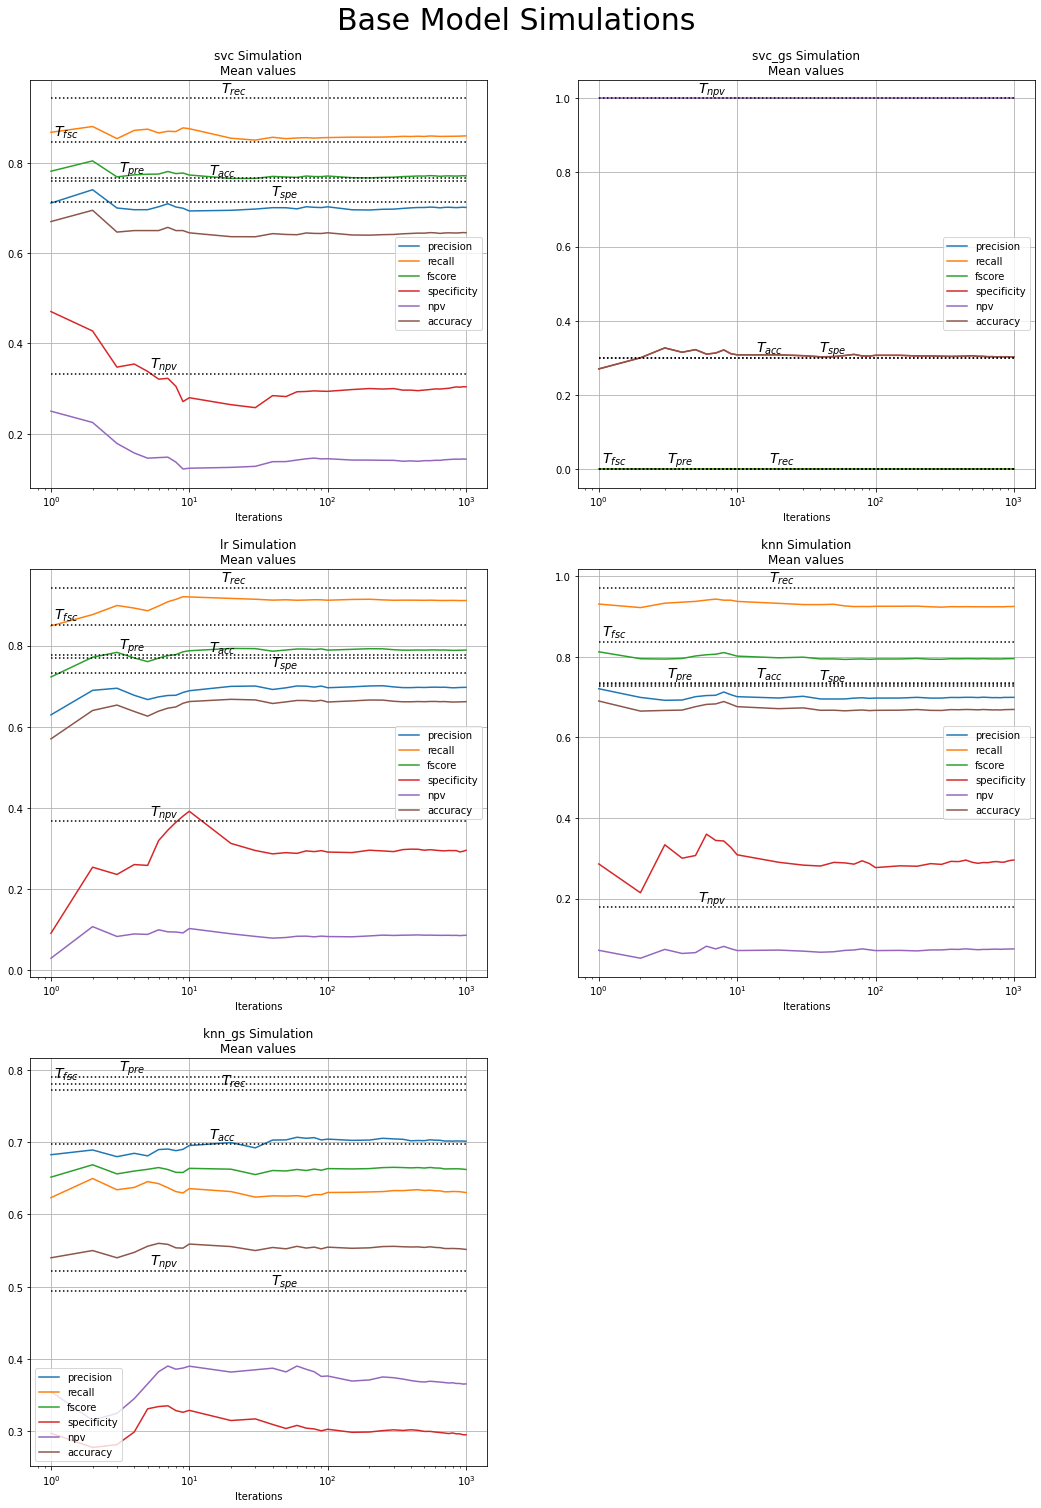

In [679]:
plot_simulations('Base Model Simulations', simulations[0], base_metrics)

### AdaBoost Models

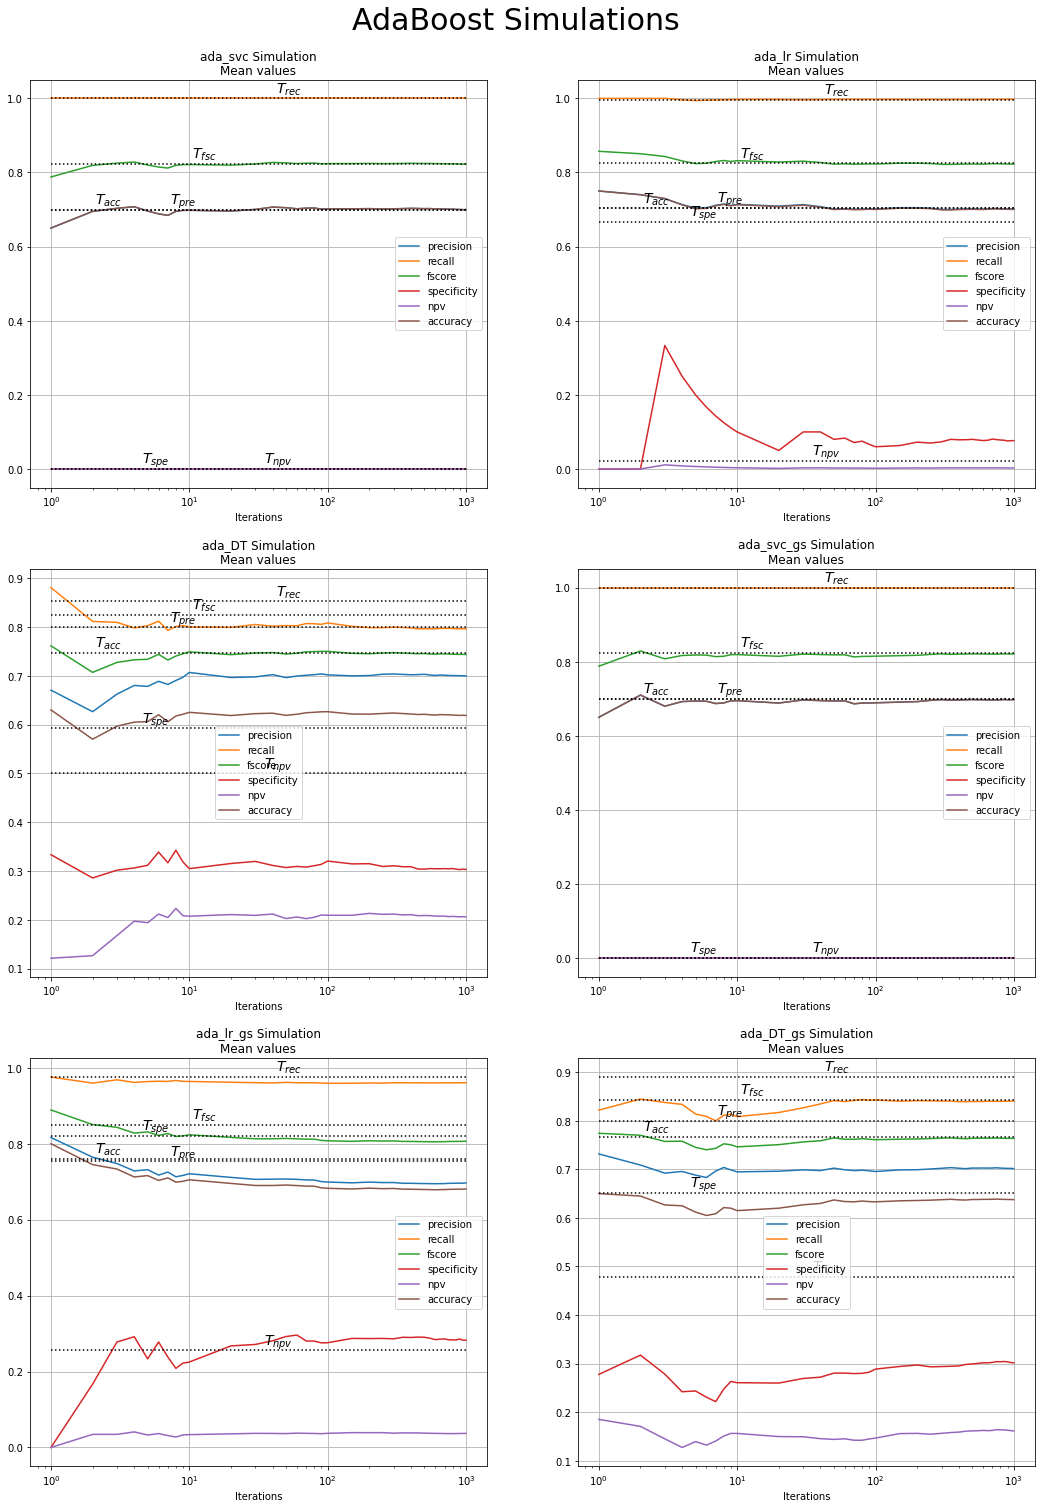

In [660]:
plot_simulations('AdaBoost Simulations', simulations[1], base_metrics)

### Voting Models

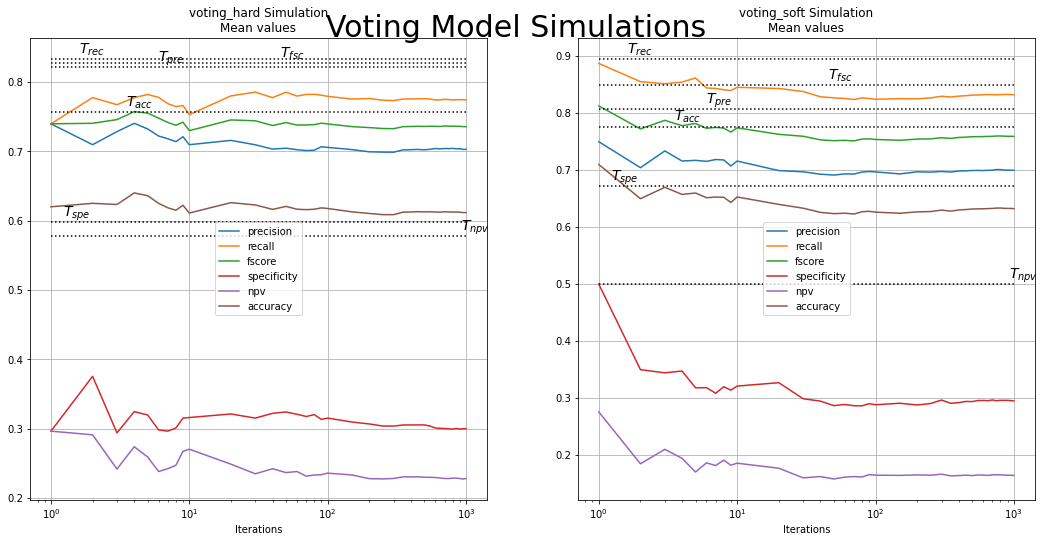

In [663]:
plot_simulations('Voting Model Simulations', simulations[2], base_metrics)

### Tree Models

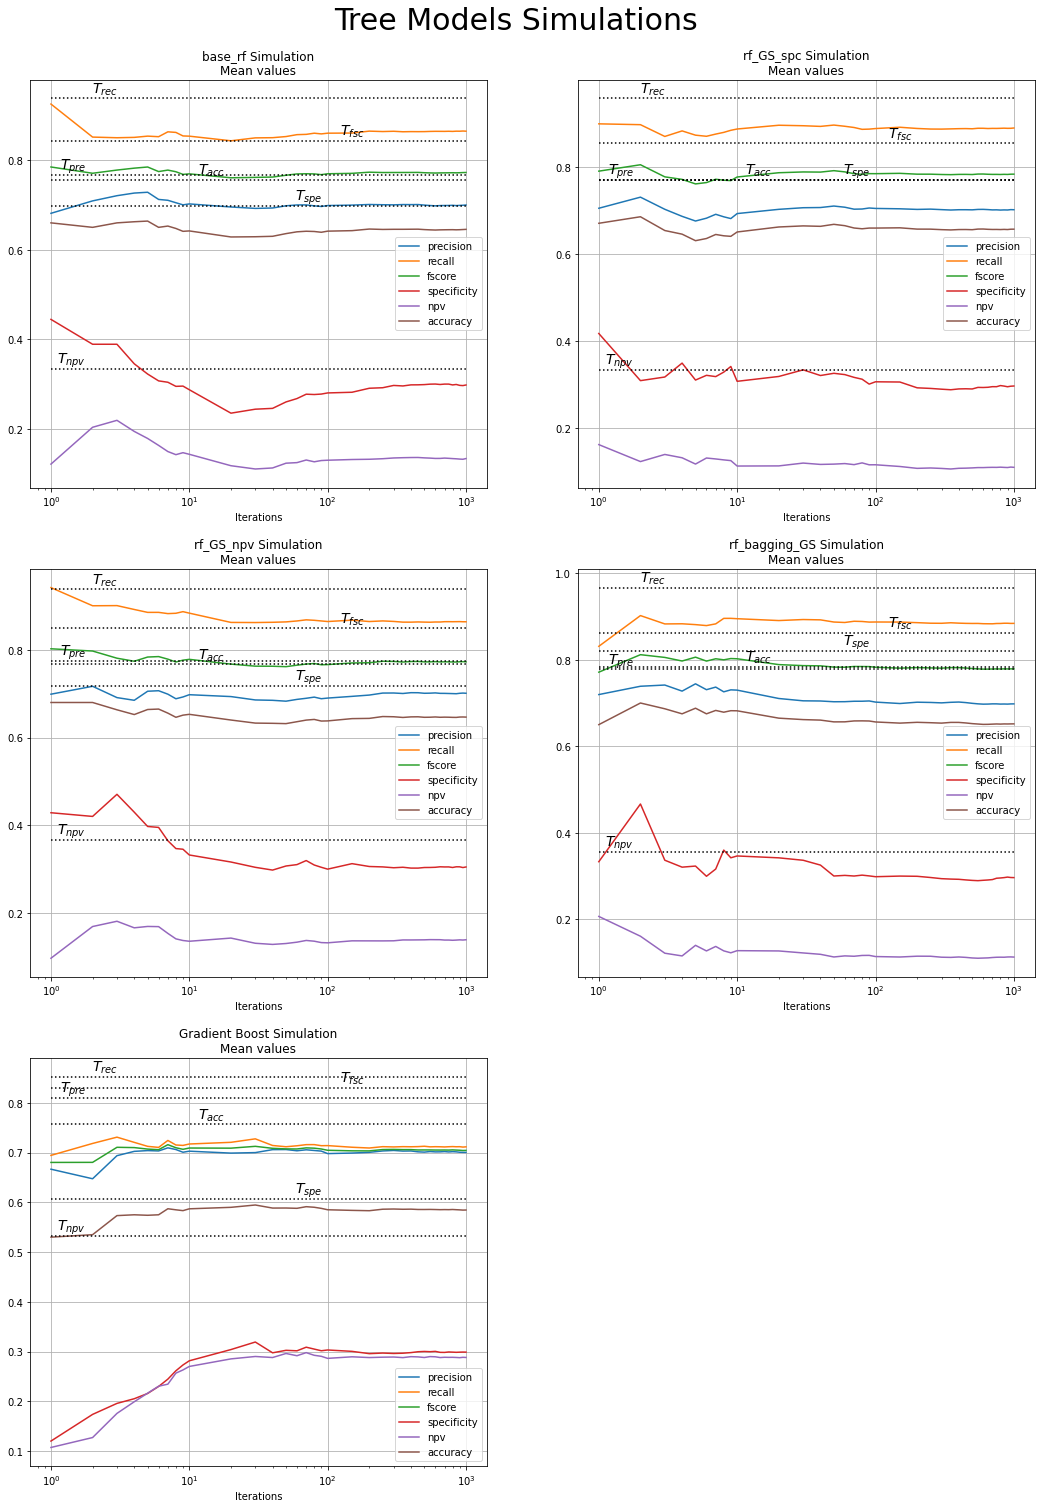

In [665]:
plot_simulations('Tree Models Simulations', simulations[3], base_metrics)

## Bar Plots

In [25]:
base_metrics

,precision,recall,fscore,specificity,npv,accuracy
svc,0.767442,0.942857,0.846154,0.714286,0.333333,0.760000
svc_gs,0.000000,0.000000,0.000000,0.300000,1.000000,0.300000
lr,0.776471,0.942857,0.851613,0.733333,0.366667,0.770000
knn,0.733813,0.971429,0.836066,0.727273,0.177778,0.733333
knn_gs,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
ada_svc,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
ada_lr,0.703704,0.995238,0.824458,0.666667,0.022222,0.703333
ada_DT,0.799107,0.852381,0.824885,0.592105,0.500000,0.746667
ada_svc_gs,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
ada_lr_gs,0.753676,0.976190,0.850622,0.821429,0.255556,0.760000


In [15]:
base_metrics.shape

(18, 6)

In [26]:
def anotate_bars(ax, bm, sm, p1):
    model_losses = []
    for rec, initial, final in zip(p1, bm.values, sm.values):
        if initial > 0:
            loss = ((final - initial)/initial)
        else:
            loss = 0
        model_losses.append(loss)
        plt.annotate('{loss:.1%}'.format(loss = loss), 
                     xy = (rec.get_x() + rec.get_width() / 2, final), 
                     xycoords = ax.transData, 
                     xytext = (0, 2), 
                     textcoords = 'offset pixels', 
                     ha = 'center', 
                     va = 'bottom',
                     size = 9.5)
    return np.array(model_losses).mean()

In [31]:
def plot_bar_simulations(title, simulation, base_metrics):
    model_loss = {}
    n = int(np.ceil(len(simulation.keys()) / 2))
    fig, axList = plt.subplots(nrows=n, ncols=2)
    axList = axList.flatten()
    fig.set_size_inches(18,8.5*n)
    for ax in enumerate(axList):
        loc = ax[0]
        ax = ax[1]
        if loc < len(simulation.keys()):
            name = list(simulation.keys())[loc]
            bm = base_metrics.loc[name[0:len(name)-11]]
            sm = simulation[name]['mean'].iloc[-1,:]
            p1 = ax.bar(bm.index, 
                        bm.values, 
                        width = 0.5, 
                        label = 'Initial Metrics')
            p2 = ax.bar(sm.index, 
                        sm.values, 
                        width = 0.5,  
                        label = 'Monte Carlo Metrics', 
                        color = 'blue')
            #ax.grid('True', axis = 'y')
            model_loss[name] = anotate_bars(ax, bm, sm, p1)
            ax.set_title(name[0:len(name)-11] + ' Model\nAverage loss: {loss:.1%}'.format(loss = model_loss[name]))
            if loc == 0:
                ax.legend()
        if loc >= len(simulation.keys()):
            ax.axis("off")
    fig.suptitle(title, y = 0.90, fontsize=30)
    return model_loss
    #plt.savefig(title + '.png', bbox_inches = 'tight')

### Base Models

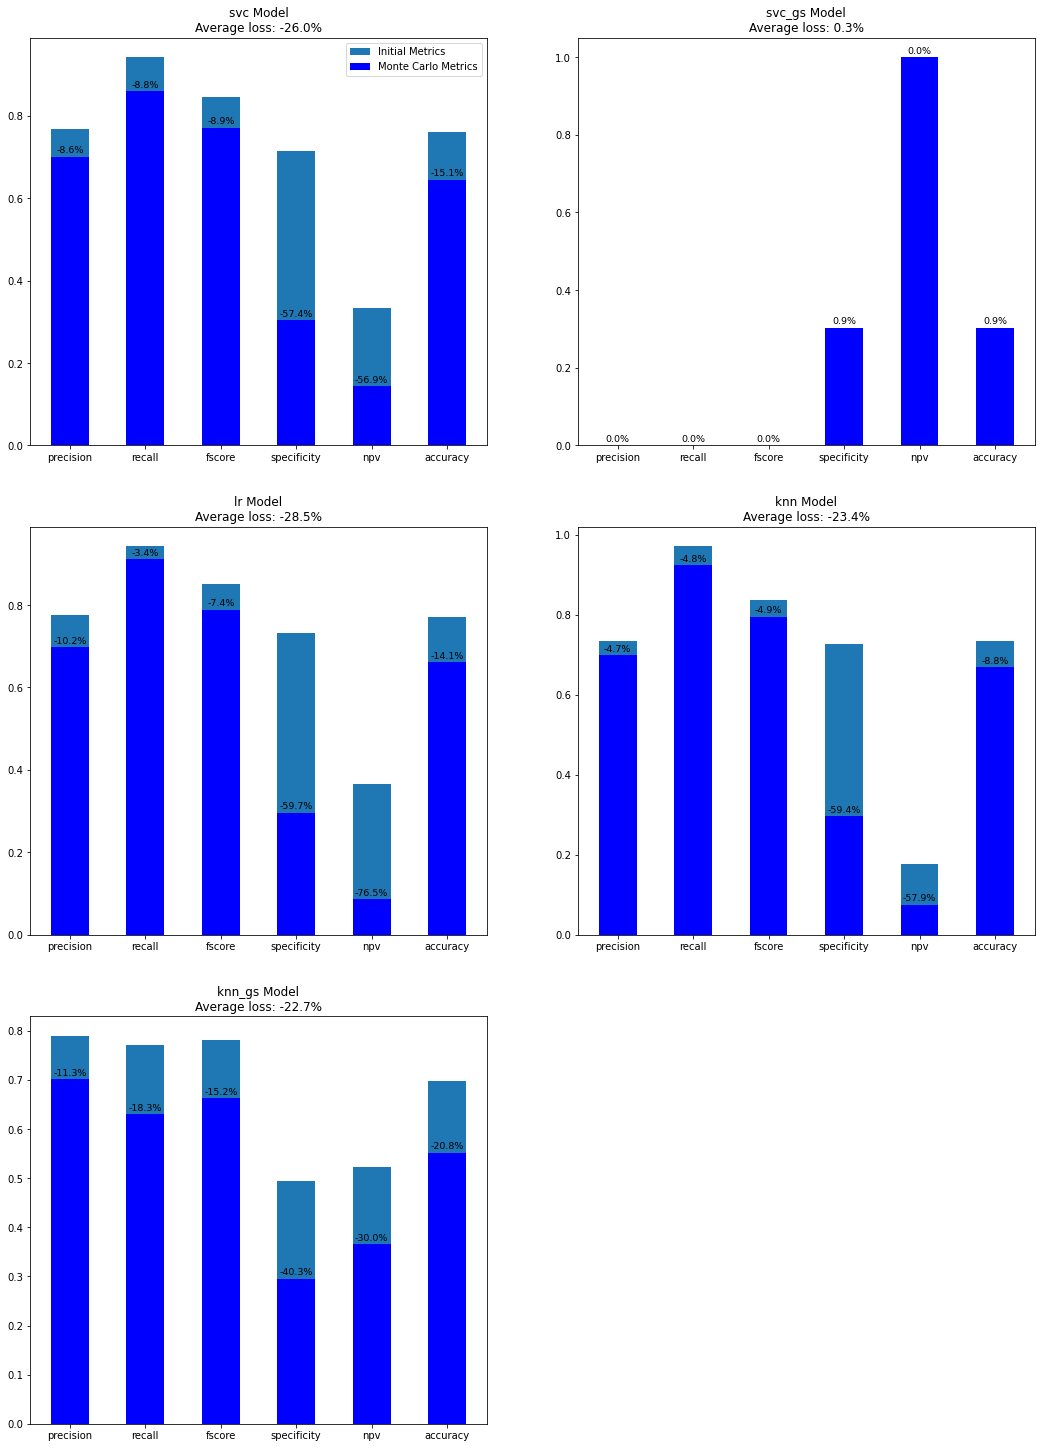

In [32]:
bm_loss = plot_bar_simulations('', simulations[0], base_metrics)

### AdaBoost Models

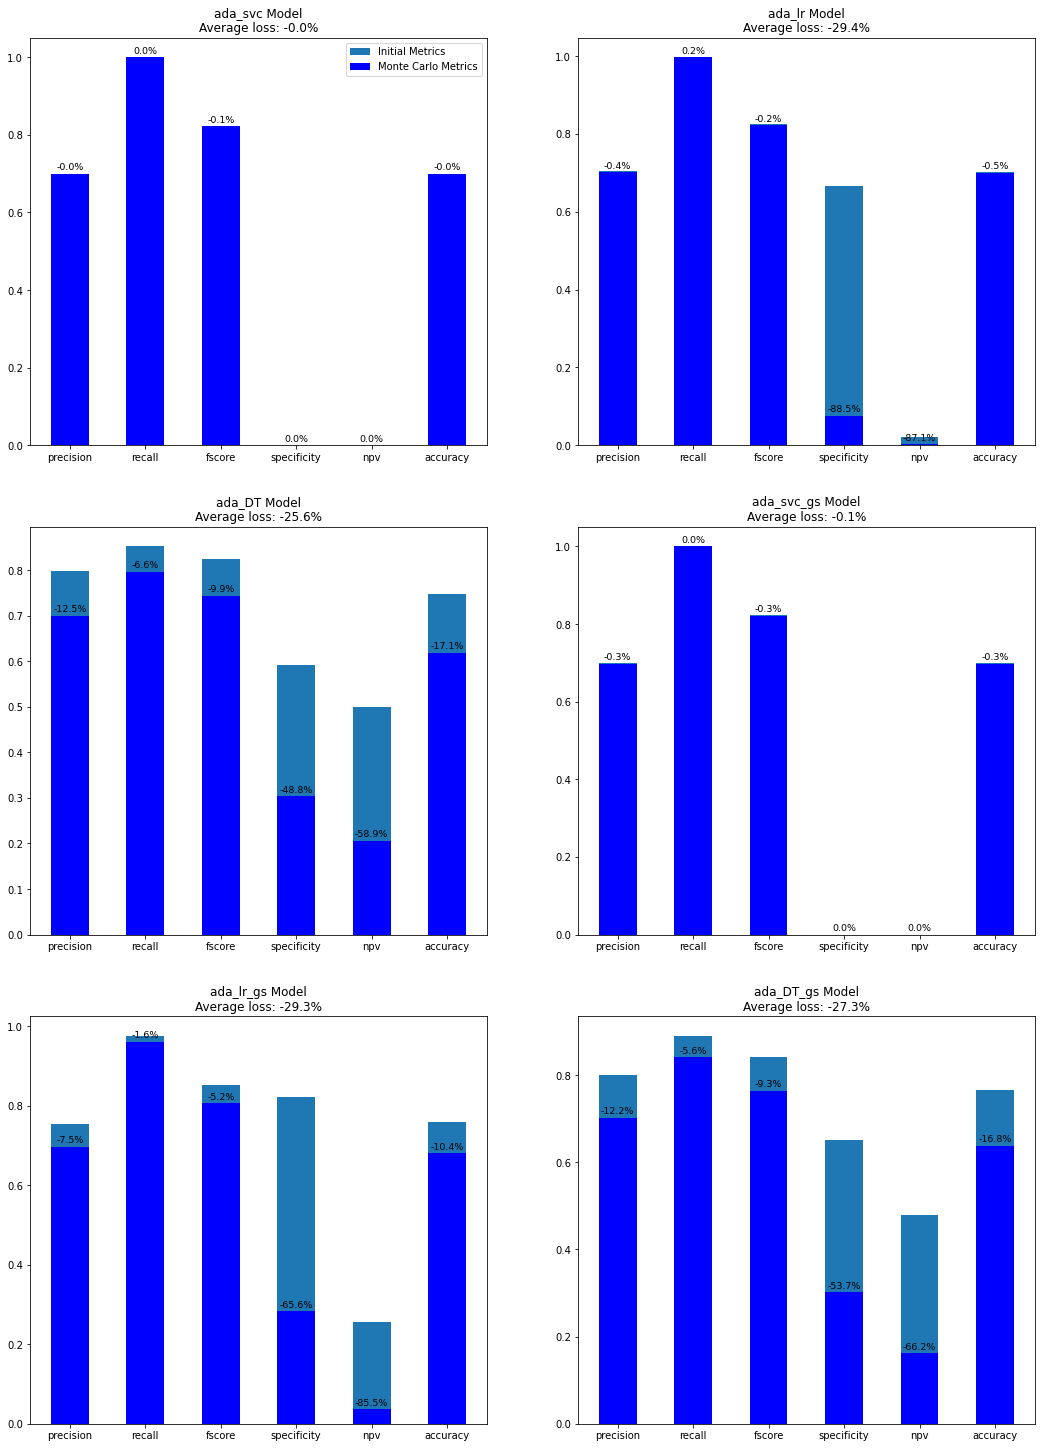

In [34]:
ada_loss = plot_bar_simulations('', simulations[1], base_metrics)

### Voting Models

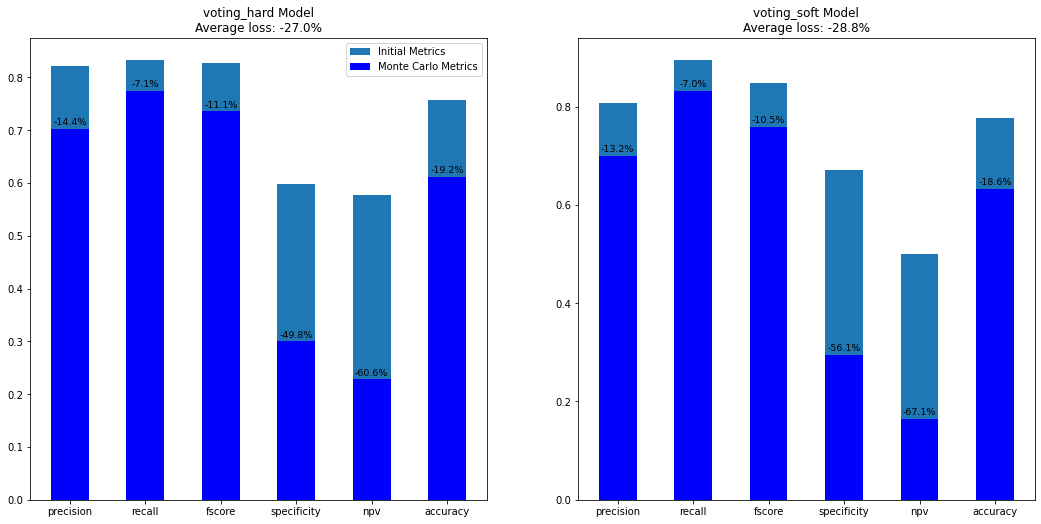

In [35]:
voting_loss = plot_bar_simulations('', simulations[2], base_metrics)

### Tree Models

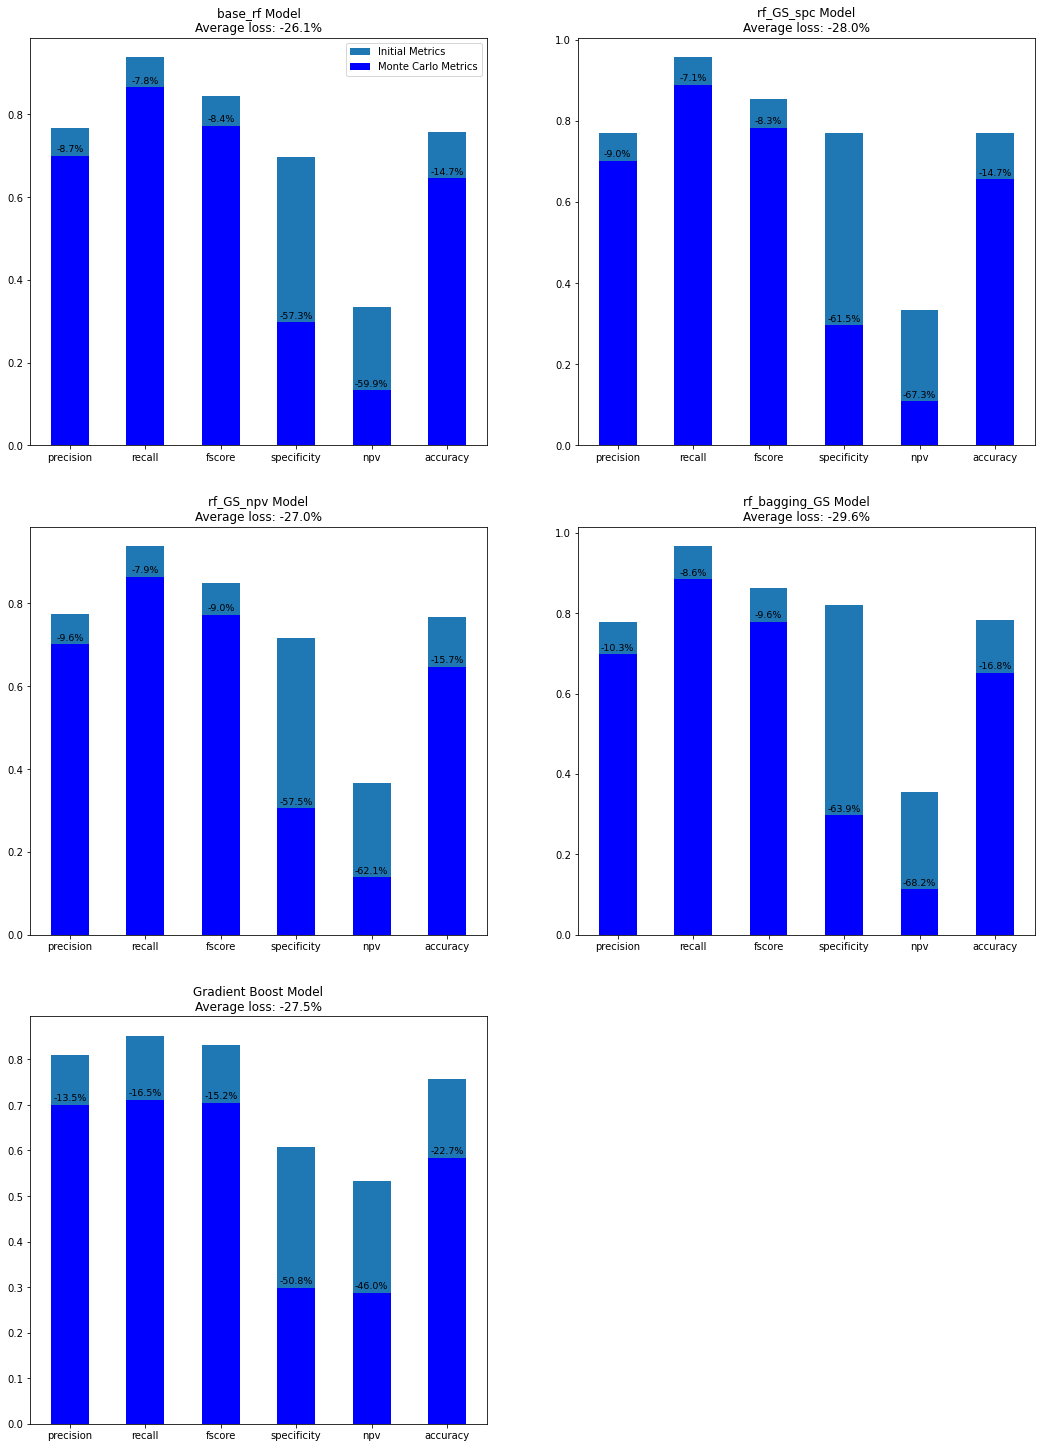

In [36]:
tree_loss = plot_bar_simulations('', simulations[3], base_metrics)

In [53]:
pd.DataFrame.from_dict(bm_loss, orient = 'index', columns = ['Model Loss'])

,Model Loss
svc Simulation,-0.259518
svc_gs Simulation,0.002922
lr Simulation,-0.285485
knn Simulation,-0.234173
knn_gs Simulation,-0.226548


In [95]:
model_loss = pd.DataFrame.from_dict(dict(list(bm_loss.items()) + list(ada_loss.items()) + list(voting_loss.items()) + list(tree_loss.items())), orient = 'index', columns = ['Average Loss'])
model_loss.sort_values(by = 'Average Loss', ascending = True, inplace = True)

In [133]:
model_loss['Average Loss'].values

array([-2.95507967e-01, -2.94151252e-01, -2.92988539e-01, -2.87533564e-01,
       -2.85485196e-01, -2.79809335e-01, -2.74606917e-01, -2.73171442e-01,
       -2.70312987e-01, -2.69605570e-01, -2.61424960e-01, -2.59518466e-01,
       -2.56225947e-01, -2.34172881e-01, -2.26547888e-01, -1.49584221e-03,
       -2.76062842e-04,  2.92222222e-03])

([], [])

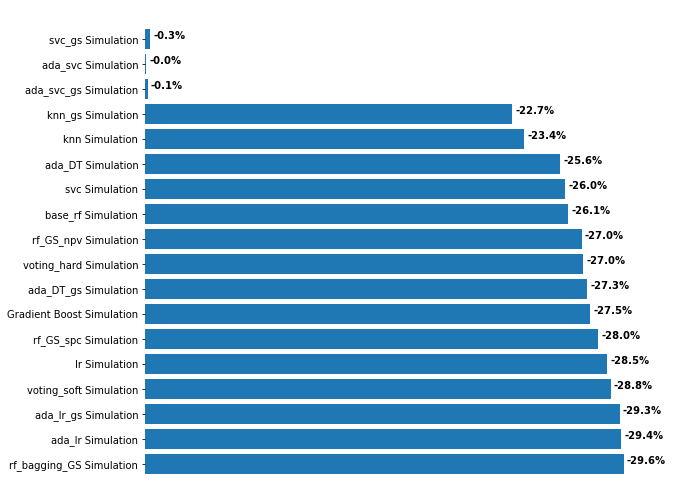

In [195]:
plt.figure(figsize = [9, 9])
bars = plt.barh(model_loss['Average Loss'].index, abs(model_loss['Average Loss'].values))
for i, v in enumerate(abs(model_loss.values)):
    plt.text(v+0.002, i, '-{val:.1%}'.format(val = v[0]), fontweight = 'bold')
plt.box(on = None)
plt.xticks(ticks = [])